In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import toml
import time
from ipywidgets import *
import cv2
import uuid
from absl import logging
logging.set_verbosity(0)

import copy
import os
import json

from datetime import datetime

In [47]:
from lc_utils import load_imu_data
from submap import Submap
from lc_utils import combine_yelli_poses, get_inverse_yelli_pose, imu_pose_estimate, normalize_pose

In [3]:
from ati.perception.lidar import lidar_pb, lidar_utils
from ati.perception.lidar.lidar_voxel import voxel_filter
from ati.perception.utils.voxel_filter_utils import voxel_filter_fast
from ati.perception.lidar.lidar_frame import *
from ati.slam.yelli import utils, grid
from utils.imu_tracker import ImuTracker

data [0.4 0.4 0.9 0.  0.9 0.4 0.9 0.2 1.  0.2 1.  0.7 0.5 0.1 0.7]
unique [0.  0.1 0.2 0.4 0.5 0.7 0.9 1. ]
sorted [0.  0.1 0.2 0.2 0.4 0.4 0.4 0.5 0.7 0.7 0.9 0.9 0.9 1.  1. ]
indices of unique values [ 0  1  2  4  7  8 10 13]
argsort [ 3 13  7  9  0  1  5 12 11 14  2  4  6  8 10]


In [74]:
max_frames = 32000 
data_dir = "/atidata/demo/comstar/2021-09-21-08-53-57-mini20-03-manual_comstar_mapping_run/"
data_dir = "/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1/2021-11-10-15-27-47-minimule-11-3-manual-FK_g+1_map_run/"
data_dir = "/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping"

bootstrap_frames =20

grid_res = 0.02
grid_alpha =1
num_submap_range_data = 90
alpha= 1.05
start_frame = 50

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
#    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
#    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 100,
    
}

grid_params['num_x'] = int((grid_params['x'][1] - grid_params['x'][0])/grid_res + 1)
grid_params['num_y'] = int((grid_params['y'][1] - grid_params['y'][0])/grid_res + 1)



zmin, zmax = 0.3, 2.5

In [75]:
z_slices = [(zmin,zmax)]
print("Using Z slices:", z_slices)

Using Z slices: [(0.3, 2.5)]


In [76]:
imu_data = load_imu_data(data_dir)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1


In [7]:
pose = np.array([0.,0., np.pi/2])
prev_pose = pose.copy()
spose = pose #local submap pose

In [77]:
submaps, active_submaps, finished_submaps = [], [], [] #active_submaps contain two two at a time -- implementation for overlapping submaps
best_scores = []
node_poses = [] #? poses of inserted frames in the global frame
inserted_frame_ids=[] #frame_id for inserted frame
submap = Submap(spose.copy(), grid_res, grid_alpha)
active_submaps.append(submap)

In [78]:
frame_id=0
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)
num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
        #continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.5)
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    
    if frame_id < start_frame + bootstrap_frames:
        print("Num Bootstrap insertions", active_submaps[0].num_insertions)
        spose = combine_yelli_poses(pose, get_inverse_yelli_pose(active_submaps[0].pose)) # pose wrt submap origin
        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id = len(node_poses)-1 )
#         frame_list.append(frame_id)
#         poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        last_inserted_pose = pose.copy()
        continue
    
    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])
    
    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose) #only theta around which we need to search changes
    spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[0].pose),pose_estimate)
    search_space = utils.grid_space(center=spose_estimate, **grid_params)
    scores = active_submaps[0].search(filtered_frame, search_space, count_once = False)
    best = np.argmax(scores)
    best_scores.append(scores[best])
    
    spose = search_space[best]
    pose = combine_yelli_poses(active_submaps[0].pose, spose)
    if (np.linalg.norm(pose[:2]-last_inserted_pose[:2])> 0.1 or (prev_insert_ts - frame_time)>1) :

        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id=len(node_poses)-1)
        if len(active_submaps) ==1:
        
            if active_submaps[0].num_insertions >= int(num_submap_range_data/2):
                active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
                s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
                active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
                #print(f"spose {spose}, s2pose {s2pose}")
                
        else:
            
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
            #print(f"len else spose {spose}, s2pose {s2pose}")
            
        if active_submaps[0].num_insertions >= num_submap_range_data - 1:
            active_submaps[0].finished = True
            finished_submaps.append(active_submaps.pop(0))
            active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose), pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
        
        #print("num active submaps", len(active_submaps))
        prev_insert_ts = frame_time
        last_inserted_pose = pose.copy()
    if frame_id % 250 == 0:
        print(f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose}  ")
    prev_frame_time, prev_frame = frame_time, frame
node_poses = np.array(node_poses)
inserted_frame_ids = np.array(inserted_frame_ids)
# print(f"final pose {poses[-1]}")
    

total frames 27638
Num Bootstrap insertions 0
Num Bootstrap insertions 1
Num Bootstrap insertions 2
Num Bootstrap insertions 3
Num Bootstrap insertions 4
Num Bootstrap insertions 5
Num Bootstrap insertions 6
Num Bootstrap insertions 7
Num Bootstrap insertions 8
Num Bootstrap insertions 9
Num Bootstrap insertions 10
Num Bootstrap insertions 11
Num Bootstrap insertions 12
Num Bootstrap insertions 13
Num Bootstrap insertions 14
Num Bootstrap insertions 15
Num Bootstrap insertions 16
Num Bootstrap insertions 17
Num Bootstrap insertions 18
Num Bootstrap insertions 19
frame:250 scores:302.0 best pose:[ 0.04395127 -0.35768671 -1.7039785 ]  
frame:500 scores:317.0 best pose:[ 0.04147709 -0.37488632 -1.70370206]  
frame:750 scores:346.0 best pose:[ 0.04208151 -0.37301475 -1.70369649]  
frame:1000 scores:287.0 best pose:[ 0.04256818 -0.37071089 -1.70360391]  
frame:1250 scores:2501.0 best pose:[ -2.63989608 -16.11824711  -1.63436763]  
frame:1500 scores:2098.0 best pose:[ -5.94745052 -34.7233684

frame:24500 scores:3588.0 best pose:[-36.95061163 -62.10182182  -1.9506285 ]  
frame:24750 scores:4601.0 best pose:[-44.75136048 -79.59098015  -1.9303543 ]  
frame:25000 scores:2671.0 best pose:[-52.82197157 -97.0428787   -1.97145597]  
frame:25250 scores:3902.0 best pose:[ -61.2369932  -114.3760154    -2.00878929]  
frame:25500 scores:1377.0 best pose:[ -57.44204716 -125.90485449   -0.36667049]  
frame:25750 scores:1762.0 best pose:[ -42.30319321 -132.78197805    0.14987791]  
frame:26000 scores:2283.0 best pose:[ -34.38670806 -117.99360066    1.20013732]  
frame:26250 scores:3001.0 best pose:[ -26.31199531 -100.79757476    1.21875305]  
frame:26500 scores:1787.0 best pose:[-19.02075585 -84.99716149   1.19170297]  
frame:26750 scores:4303.0 best pose:[-14.82895822 -76.98550799   1.16614793]  
frame:27000 scores:3523.0 best pose:[ -6.40883232 -59.71346741   1.14896848]  
frame:27250 scores:2764.0 best pose:[  1.73477999 -42.33739359   1.20008242]  
frame:27500 scores:2961.0 best pose:[

<IPython.core.display.Javascript object>


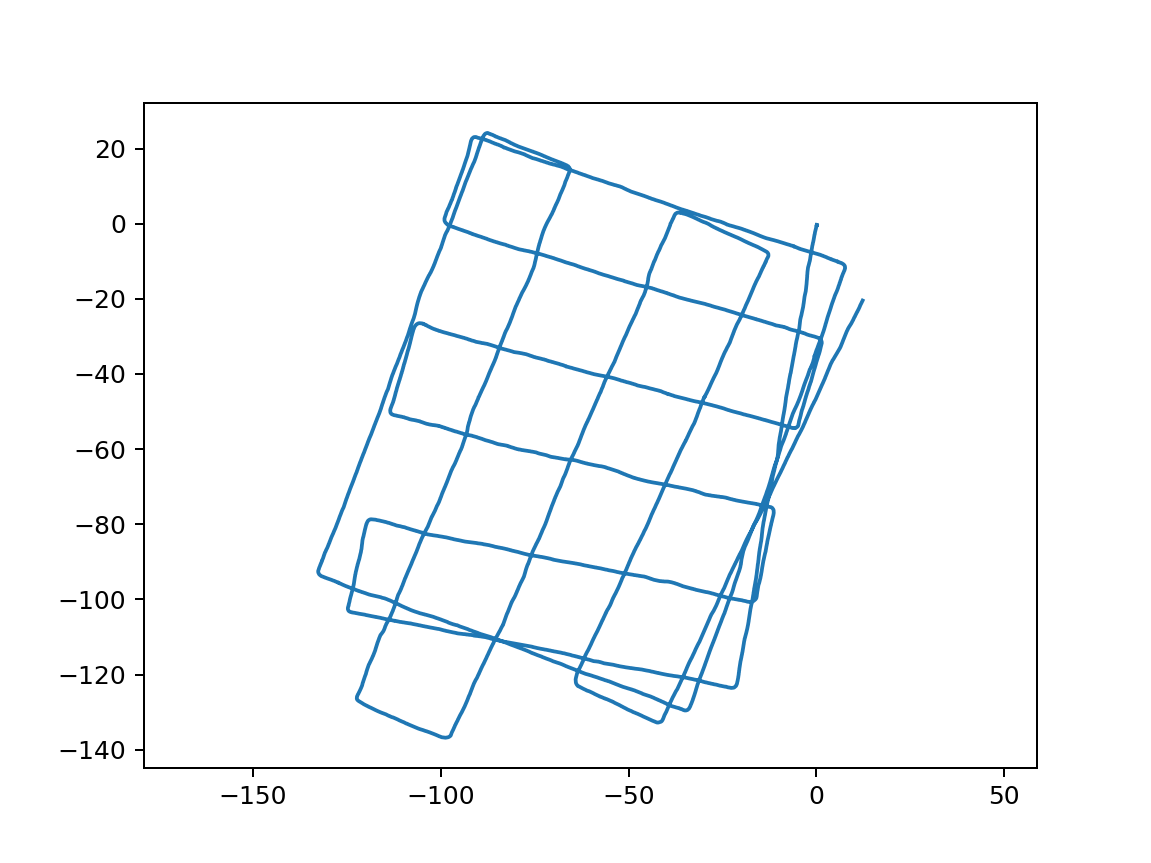

(-139.8695184274124,
 19.537536246312776,
 -144.86178105927848,
 32.21050951279277)

In [79]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
plt.axis('equal')


<IPython.core.display.Javascript object>


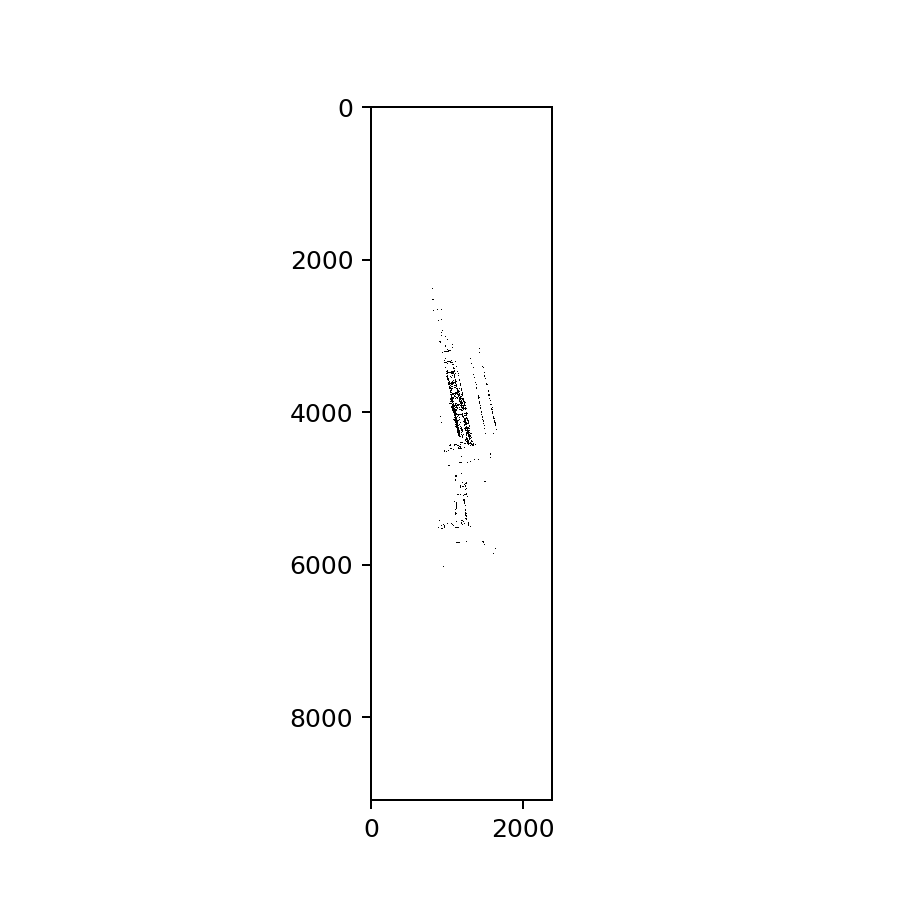

In [80]:
#%matplotlib inline
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (5,5))
#plt.imshow(1-(finished_submaps[2].grid.grid.T> 0), cmap='gray') 
plt.imshow(1 - (finished_submaps[0].grid.grid.T>0), cmap='gray') 
#print(np.sum(finished_submaps[1].grid.grid >0))

In [81]:
print( len(finished_submaps), len(node_poses), len(inserted_frame_ids))

300 13275 13275


In [82]:
import branch_bound as bb
from importlib import reload
from constraint import Constraint
import pg

reload(pg)

<module 'pg' from '/home/anujraaj/helpers/anujraaj/loop_closure/pg.py'>

In [83]:
x_search_window = (-10,10)
y_search_window = (-10,10)
angle_search_window = (-np.pi/6, np.pi/6)

node_dists = np.cumsum(np.linalg.norm(node_poses[1:,:2]-node_poses[:-1,:2], axis = 1))
node_dists = np.concatenate(([0],node_dists))
print(len(node_dists), len(node_poses))

13275 13275


In [73]:
constraints=[]
for sid in range(len(finished_submaps)):
#for sid in range(2):
    submap = finished_submaps[sid]
    hgrids =  bb.compute_hierarchical_grid(submap.grid, num_levels=4)
    for nid in range(len(node_poses)):
        npose = node_poses[nid]
        dist = np.linalg.norm(npose[:2] - submap.pose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if nid not in submap.node_ids and (dist < 10):
            fr_id = inserted_frame_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(submap.pose), npose)
            hpose = bb.hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = 50)
            print("sid, nids, pose",[submap.node_ids[0], nid], hpose)
            if hpose is not None:                
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))

Score below thresold 50 score :16.261809447558047
sid, nids, pose [0, 1982] None
Score below thresold 50 score :16.267411865864144
sid, nids, pose [0, 1983] None
Score below thresold 50 score :18.726128793486307
sid, nids, pose [0, 1984] None
Score below thresold 50 score :20.20242914979757
sid, nids, pose [0, 1986] None
Score below thresold 50 score :18.92140350877193
sid, nids, pose [0, 1987] None
Score below thresold 50 score :20.36698599852616
sid, nids, pose [0, 1988] None
Score below thresold 50 score :17.933279742765272
sid, nids, pose [0, 1989] None
Score below thresold 50 score :16.69096934548467
sid, nids, pose [0, 1990] None
Score below thresold 50 score :15.603318250377074
sid, nids, pose [0, 1991] None
Score below thresold 50 score :16.042456406368462
sid, nids, pose [0, 1994] None
Score below thresold 50 score :17.532245532245533
sid, nids, pose [0, 1995] None
Score below thresold 50 score :15.080398162327718
sid, nids, pose [0, 1996] None
Score below thresold 50 score :1

Score below thresold 50 score :13.67475035663338
sid, nids, pose [44, 2012] None
Score below thresold 50 score :14.097069597069597
sid, nids, pose [44, 2013] None
Score below thresold 50 score :15.001255492780917
sid, nids, pose [44, 2014] None
Score below thresold 50 score :14.249550089982003
sid, nids, pose [44, 2015] None
Score below thresold 50 score :14.847352024922118
sid, nids, pose [44, 2016] None
Score below thresold 50 score :15.362577107607951
sid, nids, pose [44, 2017] None
Score below thresold 50 score :13.05045871559633
sid, nids, pose [44, 2018] None
Score below thresold 50 score :13.738857938718663
sid, nids, pose [44, 2020] None
Score below thresold 50 score :15.240340537000655
sid, nids, pose [44, 2021] None
Score below thresold 50 score :14.142041851616995
sid, nids, pose [44, 2022] None
Score below thresold 50 score :13.011111111111111
sid, nids, pose [44, 2023] None
Score below thresold 50 score :14.279136690647482
sid, nids, pose [44, 2024] None
Score below threso

Score below thresold 50 score :10.73847125710676
sid, nids, pose [88, 2008] None
Score below thresold 50 score :12.333120612635609
sid, nids, pose [88, 2009] None
Score below thresold 50 score :12.095953002610965
sid, nids, pose [88, 2010] None
Score below thresold 50 score :11.47879532882606
sid, nids, pose [88, 2011] None
Score below thresold 50 score :8.193295292439373
sid, nids, pose [88, 2012] None
Score below thresold 50 score :10.076312576312576
sid, nids, pose [88, 2013] None
Score below thresold 50 score :9.904582548650346
sid, nids, pose [88, 2014] None
Score below thresold 50 score :10.65746850629874
sid, nids, pose [88, 2015] None
Score below thresold 50 score :9.516510903426791
sid, nids, pose [88, 2016] None
Score below thresold 50 score :11.427690198766278
sid, nids, pose [88, 2017] None
Score below thresold 50 score :8.474770642201834
sid, nids, pose [88, 2018] None
Score below thresold 50 score :9.343314763231199
sid, nids, pose [88, 2020] None
Score below thresold 50 

Score below thresold 50 score :10.179752066115702
sid, nids, pose [132, 1965] None
Score below thresold 50 score :9.859344894026975
sid, nids, pose [132, 1967] None
Score below thresold 50 score :10.399236641221375
sid, nids, pose [132, 1968] None
Score below thresold 50 score :9.628489620615605
sid, nids, pose [132, 1969] None
Score below thresold 50 score :9.529715762273902
sid, nids, pose [132, 1970] None
Score below thresold 50 score :9.159820282413351
sid, nids, pose [132, 1971] None
Score below thresold 50 score :10.005924950625412
sid, nids, pose [132, 1972] None
Score below thresold 50 score :8.523162939297125
sid, nids, pose [132, 1973] None
Score below thresold 50 score :8.403361344537815
sid, nids, pose [132, 1974] None
Score below thresold 50 score :8.683365446371226
sid, nids, pose [132, 1975] None
Score below thresold 50 score :9.590909090909092
sid, nids, pose [132, 1976] None
Score below thresold 50 score :8.615898959881129
sid, nids, pose [132, 1977] None
Score below t

Score below thresold 50 score :12.218816067653277
sid, nids, pose [176, 1906] None
Score below thresold 50 score :12.401803607214429
sid, nids, pose [176, 1907] None
Score below thresold 50 score :10.531221719457013
sid, nids, pose [176, 1909] None
Score below thresold 50 score :10.589692765113973
sid, nids, pose [176, 1910] None
Score below thresold 50 score :10.891713747645952
sid, nids, pose [176, 1911] None
Score below thresold 50 score :10.04
sid, nids, pose [176, 1912] None
Score below thresold 50 score :10.365896980461812
sid, nids, pose [176, 1913] None
Score below thresold 50 score :10.472694717994628
sid, nids, pose [176, 1914] None
Score below thresold 50 score :9.844145569620252
sid, nids, pose [176, 1916] None
Score below thresold 50 score :9.92601067887109
sid, nids, pose [176, 1917] None
Score below thresold 50 score :9.371517027863778
sid, nids, pose [176, 1918] None
Score below thresold 50 score :8.804030576789437
sid, nids, pose [176, 1919] None
Score below thresold 5

Score below thresold 50 score :6.766166281755196
sid, nids, pose [220, 1861] None
Score below thresold 50 score :7.200110558319514
sid, nids, pose [220, 1862] None
Score below thresold 50 score :7.482536270822139
sid, nids, pose [220, 1863] None
Score below thresold 50 score :7.632561132561133
sid, nids, pose [220, 1865] None
Score below thresold 50 score :7.452188006482982
sid, nids, pose [220, 1866] None
Score below thresold 50 score :7.1597533632287
sid, nids, pose [220, 1867] None
Score below thresold 50 score :7.3720019579050415
sid, nids, pose [220, 1868] None
Score below thresold 50 score :8.216421692853523
sid, nids, pose [220, 1869] None
Score below thresold 50 score :8.221971830985915
sid, nids, pose [220, 1871] None
Score below thresold 50 score :7.961076130509444
sid, nids, pose [220, 1872] None
Score below thresold 50 score :8.501337613697164
sid, nids, pose [220, 1873] None
Score below thresold 50 score :8.569298729983435
sid, nids, pose [220, 1874] None
Score below thres

Score below thresold 50 score :3.6124708624708624
sid, nids, pose [264, 1860] None
Score below thresold 50 score :3.6986143187066975
sid, nids, pose [264, 1861] None
Score below thresold 50 score :4.630182421227198
sid, nids, pose [264, 1862] None
Score below thresold 50 score :4.645889306824288
sid, nids, pose [264, 1863] None
Score below thresold 50 score :4.397683397683398
sid, nids, pose [264, 1865] None
Score below thresold 50 score :4.560777957860616
sid, nids, pose [264, 1866] None
Score below thresold 50 score :3.822309417040359
sid, nids, pose [264, 1867] None
Score below thresold 50 score :4.573666177190407
sid, nids, pose [264, 1868] None
Score below thresold 50 score :5.265078560567663
sid, nids, pose [264, 1869] None
Score below thresold 50 score :4.674366197183098
sid, nids, pose [264, 1871] None
Score below thresold 50 score :4.739553520320549
sid, nids, pose [264, 1872] None
Score below thresold 50 score :5.268592830390583
sid, nids, pose [264, 1873] None
Score below th

SystemError: CPUDispatcher(<function compute_half_res_grid at 0x7f011f07e7a0>) returned a result with an error set

In [45]:
#DO i need to explicitly add the vanilla constraints from scan matching?

In [66]:
g2o_nps = node_poses.copy()
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = constraints
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)


In [67]:
ps = pg.PoseGraphOptimization()
for i in range(len(g2o_nps)):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])
for i in range(len(g2o_nps)-1):
    ps.add_edge_from_state([i,i+1], information=np.identity(3))
for i in range(len(g2o_cons)-1):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 *np.identity(3))
    
ps.optimize()
oposes=[]
for i in range(len(g2o_nps)):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

In [65]:
oposes

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.25736204e-05,  1.91930371e-04, -1.83163262e-04],
       [ 8.51471382e-05,  3.83860765e-04, -3.66326722e-04],
       ...,
       [-4.67795750e-01, -3.10875070e-02,  1.58778432e+00],
       [-2.11424880e-01, -5.77792862e-02,  1.58303120e+00],
       [-1.12093255e-01, -3.64290350e-02,  1.58575808e+00]])

<IPython.core.display.Javascript object>


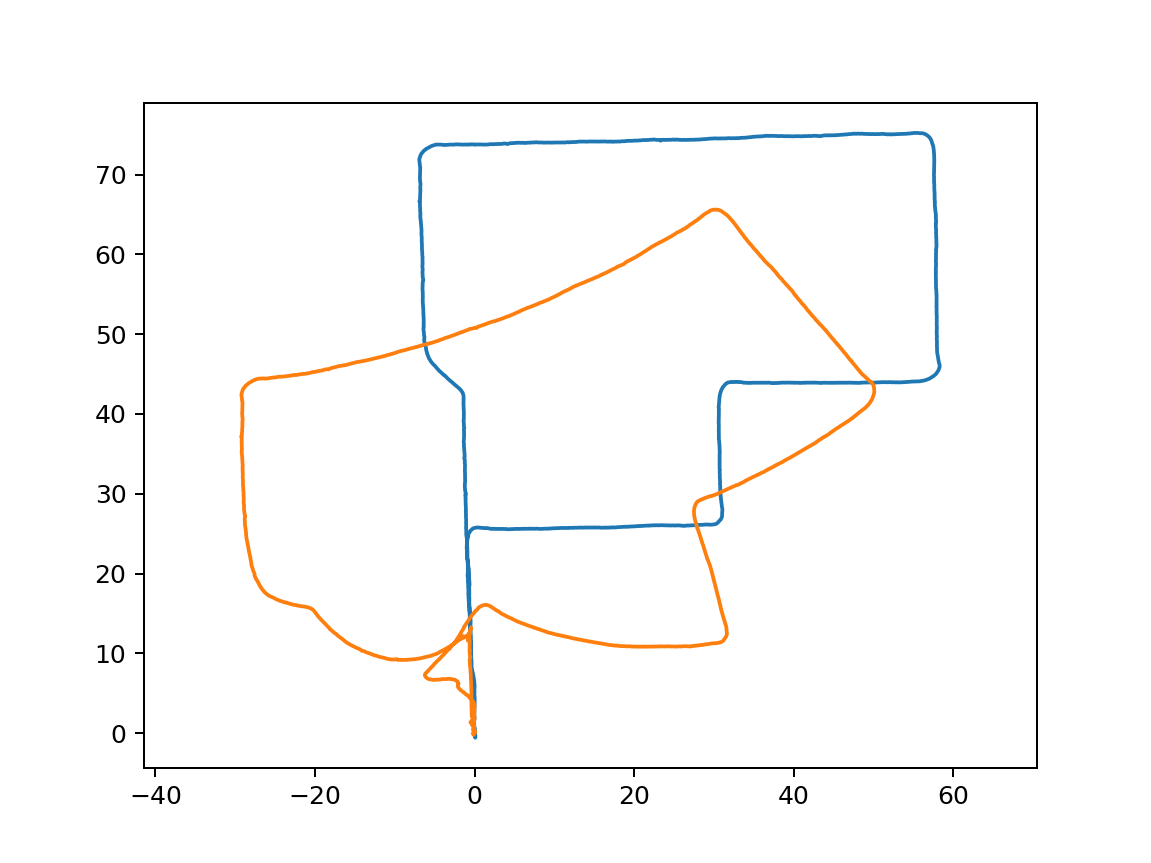

(-33.63241599518446, 62.68037790046006, -4.3695713393604585, 79.02243831664961)

In [72]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
plt.plot(oposes[st:stp,0], oposes[st:stp,1], )
plt.axis('equal')